In [1]:
%load_ext autoreload
%autoreload 2

from propose.datasets.human36m.Human36mDataset import NewestHumanDatasetNoRoot
from propose.poses.human36m import Human36mPose

from torch_geometric.loader import DataLoader

import propose.datasets.rat7m.transforms as tr
import propose.datasets.graph_transforms as trg

from propose.models.flows import CondGraphFlow
from propose.training import prior_trainer, supervised_trainer
from propose.models.nn.embedding import SageEmbedding, FlatMLPEmbedding

import torch

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

In [2]:
NewestHumanDatasetNoRoot

propose.datasets.human36m.Human36mDataset.NewestHumanDatasetNoRoot

In [4]:
dataset = NewestHumanDatasetNoRoot(
    dirname='../../data/human36m/processed',
#     num_samples=100,
    mpii=True,
    occlusion_fractions=[0.8]
) 

Loading dataset...
full pose 2D full pose 3D
2


Preparing  dataset: 100%|██████████| 387048/387048 [07:19<00:00, 880.45it/s] 


In [5]:
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

In [6]:
embedding_net = SageEmbedding(2, 128, 10) #FlatMLPEmbedding(15 * 2, 128, 16 * 10)
flow = CondGraphFlow(num_layers=10, context_features=10, hidden_features=100, embedding_net=embedding_net)
if torch.cuda.is_available(): flow.to('cuda:0')

In [20]:
lr = 1e-5
weight_decay = 0
optimizer = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=weight_decay)

In [7]:
dataset[0][0]['c'].x.shape

torch.Size([16, 2])

In [6]:
# flow.load_state_dict(torch.load('model_embedding_hrnet_occl_4.pt'))

<All keys matched successfully>

In [9]:
print(f'{sum(p.numel() for p in flow.parameters()):,}')

852,546


In [10]:
batch, base_batch, _ = next(iter(dataloader))

In [11]:
data = dataset[0][0]

x = data['c'].x
batch_size = 1

x = x.reshape(batch_size, 16, 2)

# index = x.new_ones(batch_size, 16).bool().flatten()
# index[data['c', '->', 'x'].edge_index[0]] = False
# index = index.reshape(batch_size, 16)

# index
x[:, data['c', '->', 'x'].edge_index[0]].flatten(1).shape

torch.Size([1, 30])

In [21]:
supervised_trainer(dataloader, flow, optimizer, epochs=10, device='cuda:0')

Epoch: 1/10 | Loss -3.4486 | Prior Loss -3.0219 | Posterior Loss -3.8752 | Mode Error 132.8969 | Batch : 100%|██████████| 3871/3871 [32:54<00:00,  1.96it/s]
Epoch: 2/10 | Loss -3.6316 | Prior Loss -3.0845 | Posterior Loss -4.1787 | Mode Error 112.1230 | Batch : 100%|██████████| 3871/3871 [32:48<00:00,  1.97it/s]
Epoch: 3/10 | Loss -3.7077 | Prior Loss -3.2063 | Posterior Loss -4.2092 | Mode Error 116.0682 | Batch : 100%|██████████| 3871/3871 [32:46<00:00,  1.97it/s]
Epoch: 4/10 | Loss -3.5548 | Prior Loss -3.1143 | Posterior Loss -3.9952 | Mode Error 120.3320 | Batch : 100%|██████████| 3871/3871 [32:44<00:00,  1.97it/s]
Epoch: 5/10 | Loss -3.4606 | Prior Loss -2.9667 | Posterior Loss -3.9546 | Mode Error 123.4456 | Batch : 100%|██████████| 3871/3871 [32:46<00:00,  1.97it/s]
Epoch: 6/10 | Loss -3.7819 | Prior Loss -3.2809 | Posterior Loss -4.2828 | Mode Error 105.8254 | Batch : 100%|██████████| 3871/3871 [32:47<00:00,  1.97it/s]
Epoch: 7/10 | Loss -3.6548 | Prior Loss -3.1491 | Posterio

In [22]:
torch.save(flow.state_dict(), 'model_embedding_hrnet_occl_no_mode.pt')

In [23]:
print('ok')

ok


In [27]:
from tqdm import tqdm
import pandas as pd

def evaluate(flow, test_dataloader):
    mpjpes = []

    iter_dataloader = iter(test_dataloader)
    for _ in tqdm(range(len(test_dataloader))):
        batch, _, action = next(iter_dataloader)
        batch.cuda()
        samples = flow.sample(200, batch)
        
        true_pose = batch["x"].x.cpu().numpy().reshape(-1, 16, 1, 3)
        sample_poses = samples["x"].x.detach().cpu().numpy().reshape(-1, 16, 200, 3)
        
        true_pose = np.insert(true_pose, 0, 0, axis=1)
        sample_poses = np.insert(sample_poses, 0, 0, axis=1)

#         m = np.linalg.norm((true_pose / 0.0036 - sample_poses / 0.0036)**2, axis=-1, ord=2).mean(1)#.min(-1) ** 0.5
        m = (((true_pose / 0.0036 - sample_poses / 0.0036)**2).sum(-1)**.5).mean(1)#.min(-1) ** 0.5
        m = np.min(m, axis=-1)

        m = m.tolist()
        
        mpjpes += [m]
        
#         for a, e in zip(action['action'], m):
#             if a not in mpjpes:
#                 mpjpes[a] = [e]
#             mpjpes[a].append(e)

#     dict_df = pd.DataFrame({ key: pd.Series(value) for key, value in mpjpes.items() })

#     return dict_df, np.nanmean(dict_df.to_numpy())
    return mpjpes

def mode_evaluate(flow, test_dataloader):
    mpjpes = {}

    iter_dataloader = iter(test_dataloader)
    for _ in tqdm(range(len(test_dataloader))):
        batch, _, action = next(iter_dataloader)
        batch.cuda()
        samples = flow.mode_sample(batch)

        true_pose = batch["x"].x.cpu().numpy().reshape(-1, 16, 1, 3)
        sample_poses = samples["x"].x.detach().cpu().numpy().reshape(-1, 16, 1, 3)
        
        true_pose = np.insert(true_pose, 0, 0, axis=1)
        sample_poses = np.insert(sample_poses, 0, 0, axis=1)

#         m = np.linalg.norm((true_pose / 0.0036 - sample_poses / 0.0036)**2, axis=-1, ord=2).mean(1)#.min(-1) ** 0.5
        m = (((true_pose / 0.0036 - sample_poses / 0.0036)**2).sum(-1)**.5).mean(1)#.min(-1) ** 0.5
        m = np.min(m, axis=-1)

        m = m.squeeze().tolist()

        for a, e in zip(action['action'], m):
            if a not in mpjpes:
                mpjpes[a] = [e]
            mpjpes[a].append(e)

    dict_df = pd.DataFrame({ key: pd.Series(value) for key, value in mpjpes.items() })

    return dict_df, np.nanmean(dict_df.to_numpy())

In [23]:
np.array([1]).tolist()

[1]

In [24]:
test_dataset = NewestHumanDatasetNoRoot(
    dirname='../../data/human36m/processed/test',
    occlusion_fractions=[],
    mpii=True,
    test=True,
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)

Loading dataset...
full pose 2D full pose 3D
1


Preparing test dataset: 100%|██████████| 8486/8486 [00:03<00:00, 2264.75it/s]


In [25]:
torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated()

0.015239973985973519

In [28]:
test_res = evaluate(flow, test_dataloader)

100%|██████████| 8486/8486 [14:28<00:00,  9.78it/s]


In [29]:
np.concatenate(test_res).mean()

56.2176289148216

In [34]:
test_results = np.array([52.043944326459645, 52.025560417013466, 51.94881824185032, 52.02103272221601, 52.019136865100236])
test_results.mean(), test_results.std() / np.sqrt(test_results.shape[0])

(52.011698514527936, 0.014599082042464996)

In [30]:
hard_dataset = NewestHumanDatasetNoRoot(
    dirname='../../data/human36m/processed/test',
    occlusion_fractions=[],
    hardsubset=True,
    mpii=True
)

hard_dataloader = DataLoader(hard_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)

Loading dataset...
full pose 2D full pose 3D
1


Preparing hardsubset dataset: 100%|██████████| 8739/8739 [00:03<00:00, 2227.75it/s]


In [31]:
torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated()

0.015239973985973519

In [32]:
# hard_df, hard_mean = evaluate(flow, hard_dataloader)
# hard_mean
hard_res = evaluate(flow, hard_dataloader)
np.concatenate(hard_res).mean()

100%|██████████| 8739/8739 [14:56<00:00,  9.75it/s]


91.40692024763504

In [37]:
hard_results = np.array([78.70210373997756, 78.63778696956126, 78.5864084010021, 78.70593371065547])
hard_results.mean(), hard_results.std() / np.sqrt(hard_results.shape[0])

(78.6580582052991, 0.024719287247481916)

In [336]:
batch, _, _, = test_dataset[0]
batch

HeteroData(
  x={ x=[16, 3] },
  c={ x=[16, 2] },
  r={ x=[1, 3] },
  (x, ->, x)={ edge_index=[2, 13] },
  (x, <-, x)={ edge_index=[2, 13] },
  (c, ->, x)={ edge_index=[2, 15] },
  (r, ->, x)={ edge_index=[2, 3] }
)

In [335]:
batch, _, _, = dataset[100]
batch

HeteroData(
  x={ x=[16, 3] },
  c={ x=[16, 2] },
  r={ x=[1, 3] },
  (x, ->, x)={ edge_index=[2, 13] },
  (x, <-, x)={ edge_index=[2, 13] },
  (c, ->, x)={ edge_index=[2, 15] },
  (r, ->, x)={ edge_index=[2, 3] }
)

In [47]:
eval_dataset = NewestHumanDatasetNoRoot(
    dirname='../../data/human36m/processed',
    occlusion_fractions=[],
    mpii=True,
    num_samples=10000
)
eval_dataloader = DataLoader(eval_dataset, batch_size=10, shuffle=True, pin_memory=False, num_workers=0)

Loading dataset...
full pose 2D full pose 3D
1


Preparing  dataset: 100%|██████████| 10000/10000 [00:05<00:00, 1973.51it/s]


In [202]:
eval_df, eval_mean = evaluate(flow, eval_dataloader)
eval_mean

100%|██████████| 1000/1000 [02:12<00:00,  7.57it/s]


41.944527966794354

In [187]:
x3d = batch['x'].x.numpy()
x3d = np.insert(x3d, 0, 0, axis=0)

x2d = batch['c'].x.numpy()
x2d = np.insert(x2d, 0, 0, axis=0)
print(x2d.shape)
# x2d = x2d.swapaxes(1, 0)

pose3d = Human36mPose(x3d)
pose2d = Human36mPose(x2d)

plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.view_init(0, 90)
pose3d.plot(ax)
plt.show()

plt.figure(figsize=(5, 5))
ax = plt.axes()
pose2d.plot(ax)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [27]:
pose2d

Human36mPose(shape=(3201, 2), pose_matrix=array([[ 0.        ,  0.        ],
       [ 0.23473345,  0.03162687],
       [ 0.16325596, -0.76398504],
       ...,
       [-0.23026095,  0.90378344],
       [-0.67491907,  0.76607096],
       [-1.1178762 ,  0.7365826 ]], dtype=float32))

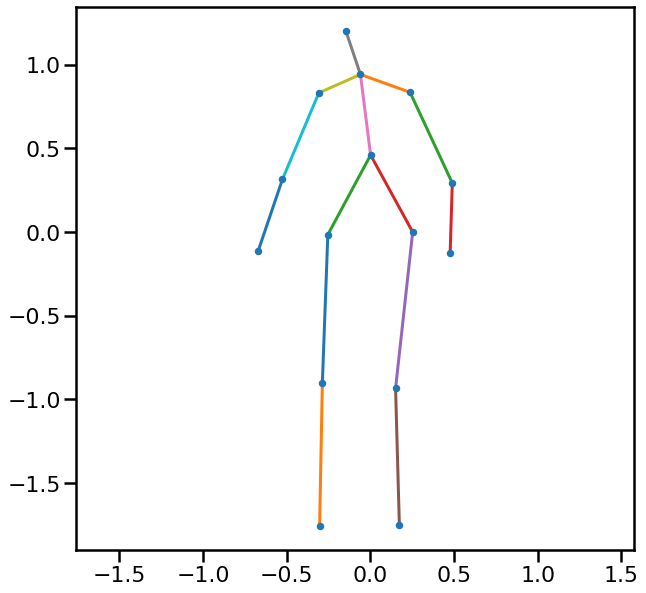

In [123]:
BONES17j = [[0, 1], [1, 2], [2, 3], [0, 4], [4, 5], [5, 6], [0, 7], [7, 8],
            [8, 9], [9, 10], [8, 11], [11, 12], [12, 13], [8, 14], [14, 15], [15, 16]]

BONES16j_MPII = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5], [6, 7], [7, 8],
                 [8, 9], [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15]]

BONES16j_H36M = [[0, 1], [1, 2], [0, 6], [6, 3], [3, 4], [4, 5], [6, 7], [7, 9],
                 [7, 13], [13, 14], [14, 15], [7, 10], [10, 11], [11, 12]]

mpii_2_h36m = [6, 2, 1, 0, 3, 4, 5, 7, 8, 9, 13, 14, 15, 12, 11, 10]

def plot2d_16j(pose, mpii_skeleton=True):
    # plots a single 2D pose (MPII skeleton)
    assert pose.size == 2 * 16
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()

    pose = pose.flatten()
    x = pose[0:16]
    y = pose[16:32]
    
    ax.scatter(x[:8], y[:8], s=30, zorder=10)
    ax.scatter(x[9:], y[9:], s=30, c='tab:blue', zorder=10)

    if mpii_skeleton:
        B = BONES16j_MPII
    else:
        B = BONES16j_H36M
    for l in range(len(B)):
        
        ax.plot(x[B[l]], y[B[l]], lw=3)

    plt.axis('equal')
    plt.show()
    plt.close()


x2d = batch['c'].x.cpu().numpy().swapaxes(0, 1)
plot2d_16j(x2d.flatten(), mpii_skeleton=False)

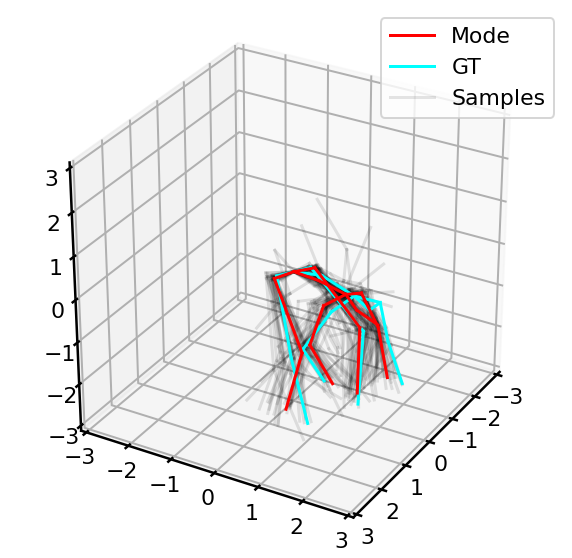

In [32]:
sns.set_context('poster')
viz_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)
batch, _, config = next(iter(viz_dataloader))

# missing_nodes = list(set(range(0, 16)) - set(batch['c', '->', 'x'].edge_index[0].tolist()))
# for node in missing_nodes:
#     print(og_pose.marker_names[node])
original = batch['x'].x.numpy()
original_2d = batch['c'].x.numpy()#camera.proj2D(original)
# original_2d[..., 0] *= -1

original = np.insert(original, 0, 0, 0)
original_2d = np.insert(original_2d, 0, 0, 0)

og_pose = Human36mPose(original)
og_pose_2d = Human36mPose(original_2d)

samples = flow.sample(30, batch.cuda())

sample_poses = samples['x'].x.detach().cpu().numpy()
sample_poses = np.insert(sample_poses, 0, 0, 0)
sample_poses = sample_poses.swapaxes(0, 1)

poses = Human36mPose(sample_poses)

mode = flow.mode_sample(batch.cuda())['x']['x'].detach().cpu().numpy()
mode = np.insert(mode, 0, 0, 0)
mode = mode.swapaxes(0, 1)
mode = Human36mPose(mode)

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.view_init(30, 30)
poses.plot(ax, plot_type='None', c='k', alpha=0.1)
og_pose.plot(ax, plot_type='None', c='cyan')
mode.plot(ax, plot_type='None', c='r')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='r', label='Mode'),
                   Line2D([0], [0], color='cyan', label='GT'),
                   Line2D([0], [0], color='k', alpha=0.1, label='Samples'),
                  ]

ax.legend(handles=legend_elements)
plt.show()

# camera = cameras[config['subject'][0]][config['camera'][0]]

og_pose_2d.pose_matrix[..., 0] *= -1
# plt.figure(figsize=(10, 10))
# ax = plt.axes()
# og_pose_2d.plot(ax)
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# # ax.view_init(0, 90)
# # poses.plot(ax, plot_type='None', c='k', alpha=0.25)
# # og_pose.plot(ax)
# # ax.set_xlim(-3, 3)
# # ax.set_ylim(-3, 3)
# # ax.set_zlim(-3, 3)
# plt.show()

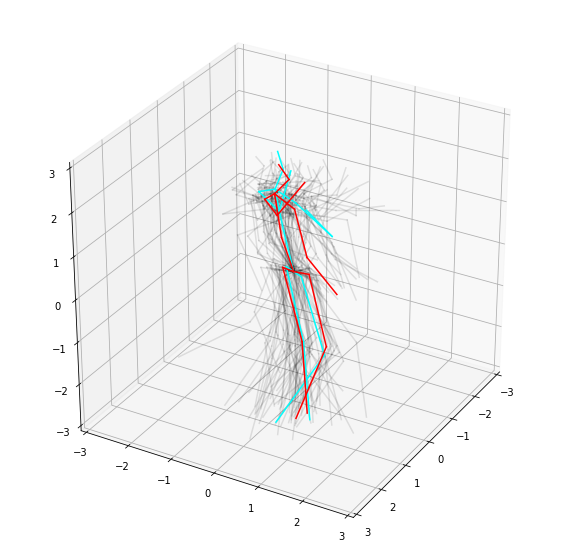

In [20]:

viz_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)
batch, _, config = next(iter(viz_dataloader))

# missing_nodes = list(set(range(0, 16)) - set(batch['c', '->', 'x'].edge_index[0].tolist()))
# for node in missing_nodes:
#     print(og_pose.marker_names[node])
original = batch['x'].x.numpy()
original_2d = batch['c'].x.numpy()#camera.proj2D(original)
# original_2d[..., 0] *= -1

original = np.insert(original, 0, 0, 0)
original_2d = np.insert(original_2d, 0, 0, 0)

og_pose = Human36mPose(original)
og_pose_2d = Human36mPose(original_2d)

samples = flow.sample(30, batch.cuda())

sample_poses = samples['x'].x.detach().cpu().numpy()
sample_poses = np.insert(sample_poses, 0, 0, 0)
sample_poses = sample_poses.swapaxes(0, 1)

poses = Human36mPose(sample_poses)

mode = flow.mode_sample(batch.cuda())['x']['x'].detach().cpu().numpy()
mode = np.insert(mode, 0, 0, 0)
mode = mode.swapaxes(0, 1)
mode = Human36mPose(mode)

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.view_init(30, 30)
poses.plot(ax, plot_type='None', c='k', alpha=0.1)
og_pose.plot(ax, plot_type='None', c='cyan')
mode.plot(ax, plot_type='None', c='r')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
# plt.legend(['GT', 'Mode'])
plt.show()

# camera = cameras[config['subject'][0]][config['camera'][0]]

og_pose_2d.pose_matrix[..., 0] *= -1
# plt.figure(figsize=(10, 10))
# ax = plt.axes()
# og_pose_2d.plot(ax)
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# # ax.view_init(0, 90)
# # poses.plot(ax, plot_type='None', c='k', alpha=0.25)
# # og_pose.plot(ax)
# # ax.set_xlim(-3, 3)
# # ax.set_ylim(-3, 3)
# # ax.set_zlim(-3, 3)
# plt.show()

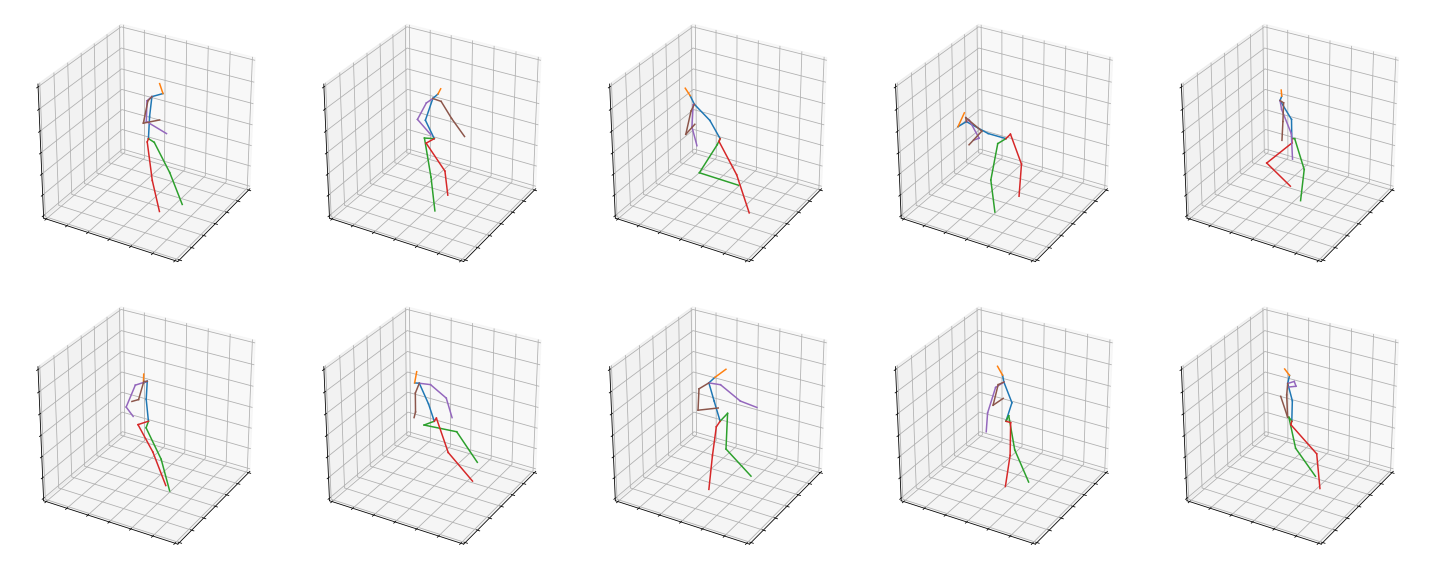

In [12]:
viz_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)
_, batch, config = next(iter(viz_dataloader))

# missing_nodes = list(set(range(0, 16)) - set(batch['c', '->', 'x'].edge_index[0].tolist()))
# for node in missing_nodes:
#     print(og_pose.marker_names[node])
original = batch['x'].x.numpy()
# original_2d = batch['c'].x.numpy()#camera.proj2D(original)
# original_2d[..., 0] *= -1

original = np.insert(original, 0, 0, 0)
# original_2d = np.insert(original_2d, 0, 0, 0)

# og_pose = Human36mPose(original)
# og_pose_2d = Human36mPose(original_2d)

samples = flow.sample(30, batch.cuda())

sample_poses = samples['x'].x.detach().cpu().numpy()
sample_poses = np.insert(sample_poses, 0, 0, 0)
sample_poses = sample_poses.swapaxes(0, 1)

poses = Human36mPose(sample_poses)

mode = flow.mode_sample(batch.cuda())['x']['x'].detach().cpu().numpy()
mode = np.insert(mode, 0, 0, 0)
mode = mode.swapaxes(0, 1)
mode = Human36mPose(mode)

fig = plt.figure(figsize=(20, 8))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, projection='3d')
    ax.view_init(30, 30)
    poses[i].plot(ax)
#     og_pose.plot(ax, plot_type='None', c='cyan')
#     mode.plot(ax, plot_type='None', c='r')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-3, 3)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
plt.tight_layout()
#     plt.legend(['GT', 'Mode'])
plt.show()

# camera = cameras[config['subject'][0]][config['camera'][0]]

# og_pose_2d.pose_matrix[..., 0] *= -1
# plt.figure(figsize=(10, 10))
# ax = plt.axes()
# og_pose_2d.plot(ax)
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# # ax.view_init(0, 90)
# # poses.plot(ax, plot_type='None', c='k', alpha=0.25)
# # og_pose.plot(ax)
# # ax.set_xlim(-3, 3)
# # ax.set_ylim(-3, 3)
# # ax.set_zlim(-3, 3)
# plt.show()

tensor(2.8346, device='cuda:0', grad_fn=<MeanBackward0>)
(17, 3)


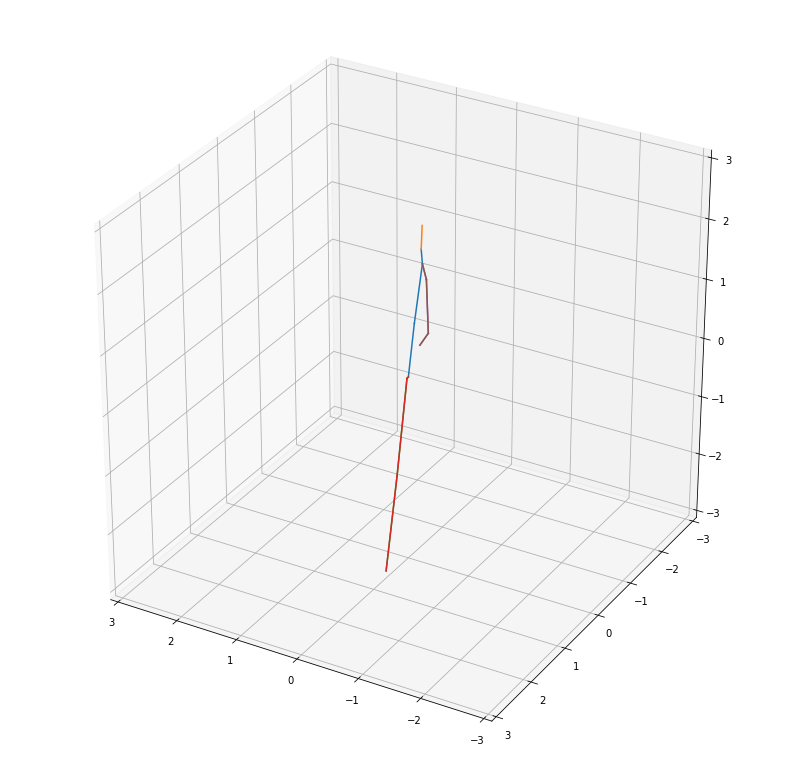

In [11]:
viz_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)
_, base_batch, config = next(iter(viz_dataloader))

# missing_nodes = list(set(range(0, 16)) - set(batch['c', '->', 'x'].edge_index[0].tolist()))
# for node in missing_nodes:
#     print(og_pose.marker_names[node])
# original = batch['x'].x.numpy()
# original_2d = batch['c'].x.numpy()#camera.proj2D(original)
# original_2d[..., 0] *= -1

# original = np.insert(original, 0, 0, 0)
# original_2d = np.insert(original_2d, 0, 0, 0)

# og_pose = Human36mPose(original)
# og_pose_2d = Human36mPose(original_2d)

samples = flow.mode_sample(base_batch.cuda())
print(flow.log_prob(samples).mean())

sample_poses = samples['x'].x.detach().cpu().numpy().squeeze()
sample_poses = np.insert(sample_poses, 0, 0, 0)
# sample_poses = sample_poses.swapaxes(0, 1)

print(sample_poses.shape)
poses = Human36mPose(sample_poses)

# mode = flow.mode_sample(batch.cuda())['x']['x'].detach().cpu().numpy()
# mode = np.insert(mode, 0, 0, 0)
# mode = mode.swapaxes(0, 1)
# mode = Human36mPose(mode)

plt.figure(figsize=(14, 14))
ax = plt.axes(projection='3d')
ax.view_init(30, 120)
poses.plot(ax)
# og_pose.plot(ax, plot_type='None', c='cyan')
# mode.plot(ax, plot_type='None', c='r')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

# camera = cameras[config['subject'][0]][config['camera'][0]]

# og_pose_2d.pose_matrix[..., 0] *= -1
# plt.figure(figsize=(10, 10))
# ax = plt.axes()
# og_pose_2d.plot(ax)
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# # ax.view_init(0, 90)
# # poses.plot(ax, plot_type='None', c='k', alpha=0.25)
# # og_pose.plot(ax)
# # ax.set_xlim(-3, 3)
# # ax.set_ylim(-3, 3)
# # ax.set_zlim(-3, 3)
# plt.show()

In [4]:
test_dataset = NewestHumanDatasetNoRoot(
    dirname='../../data/human36m/processed/test',
    occlusion_fractions=[],
    mpii=True,
    test=True
)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True, pin_memory=False, num_workers=0)

Loading dataset...
full pose 2D full pose 3D
1


Preparing test dataset: 100%|██████████| 8486/8486 [00:04<00:00, 1820.05it/s]


In [18]:
viz_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, pin_memory=False, num_workers=0)
_, base_batch, config = next(iter(viz_dataloader))

# base_batch['x']['x'] = torch.randn(16, 3) * 1

# sample, _ = flow._transform.inverse(base_batch.cuda())
flow.log_prob(base_batch)
# sample_poses = sample['x'].x.detach().cpu().numpy().squeeze()
# sample_poses = np.insert(sample_poses, 0, 0, 0)

# poses = Human36mPose(sample_poses)

# plt.figure(figsize=(7, 7))
# ax = plt.axes(projection='3d')
# ax.view_init(30, 120)
# poses.plot(ax)

# ax.set_xlim(-3, 3)
# ax.set_ylim(-3, 3)
# ax.set_zlim(-3, 3)
# plt.show()

# base_batch['x', '->', 'x']

tensor([-737.3611, -727.1469], grad_fn=<AddBackward0>)

In [36]:
from propose.models.distributions import StandardNormal

StandardNormal((3, )).log_prob(torch.randn(2, 16, 3)) / 16

tensor([-1.7268, -2.2176])

In [176]:
import pickle
with open('../../data/human36m/processed/test/cameras.pkl', 'rb') as f:
    cameras = pickle.load(f)

{'S1': {'54138969': <Camera fx=1145.05 fy=1143.78 cx=512.54 cy=515.45 skew=0.00>,
  '55011271': <Camera fx=1149.68 fy=1147.59 cx=508.85 cy=508.06 skew=0.00>,
  '58860488': <Camera fx=1149.14 fy=1148.80 cx=519.82 cy=501.40 skew=0.00>,
  '60457274': <Camera fx=1145.51 fy=1144.77 cx=514.97 cy=501.88 skew=0.00>},
 'S5': {'54138969': <Camera fx=1145.05 fy=1143.78 cx=512.54 cy=515.45 skew=0.00>,
  '55011271': <Camera fx=1149.68 fy=1147.59 cx=508.85 cy=508.06 skew=0.00>,
  '58860488': <Camera fx=1149.14 fy=1148.80 cx=519.82 cy=501.40 skew=0.00>,
  '60457274': <Camera fx=1145.51 fy=1144.77 cx=514.97 cy=501.88 skew=0.00>},
 'S6': {'54138969': <Camera fx=1145.05 fy=1143.78 cx=512.54 cy=515.45 skew=0.00>,
  '55011271': <Camera fx=1149.68 fy=1147.59 cx=508.85 cy=508.06 skew=0.00>,
  '58860488': <Camera fx=1149.14 fy=1148.80 cx=519.82 cy=501.40 skew=0.00>,
  '60457274': <Camera fx=1145.51 fy=1144.77 cx=514.97 cy=501.88 skew=0.00>},
 'S7': {'54138969': <Camera fx=1145.05 fy=1143.78 cx=512.54 cy=515.

ValueError: Cannot take a larger sample than population when 'replace=False'

In [93]:
mean_pose = torch.cat([d['x']['x'].reshape(-1, 16, 3) for d in test_dataset.base_data]).mean(0)

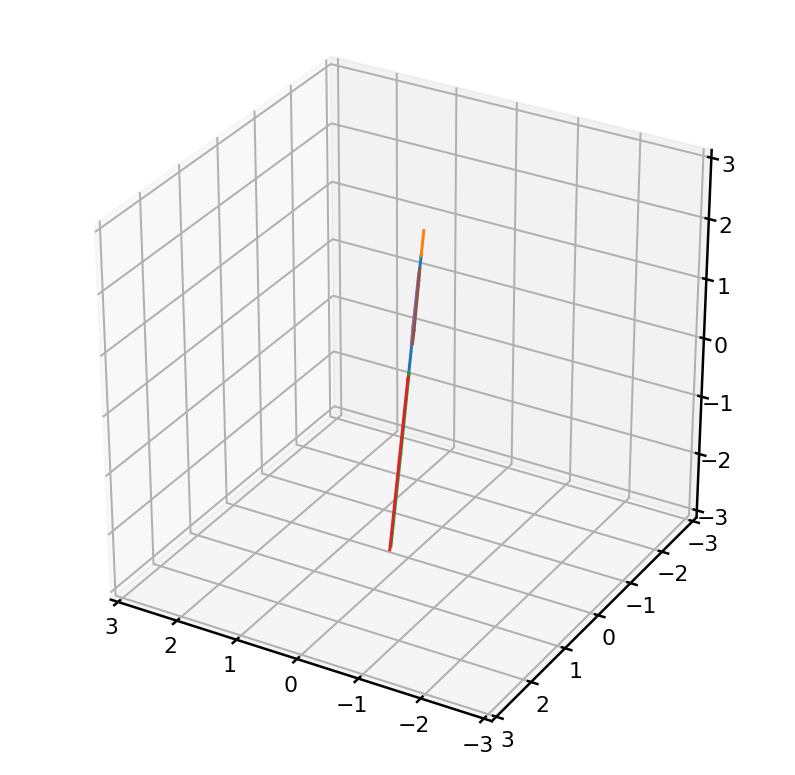

In [101]:
sample_poses = mean_pose.detach().cpu().numpy().squeeze()
sample_poses = np.insert(sample_poses, 0, 0, 0)
# sample_poses = sample_poses.swapaxes(0, 1)

poses = Human36mPose(sample_poses)

# mode = flow.mode_sample(batch.cuda())['x']['x'].detach().cpu().numpy()
# mode = np.insert(mode, 0, 0, 0)
# mode = mode.swapaxes(0, 1)
# mode = Human36mPose(mode)

plt.figure(figsize=(14, 14))
ax = plt.axes(projection='3d')
ax.view_init(30, 120)
poses.plot(ax)
# og_pose.plot(ax, plot_type='None', c='cyan')
# mode.plot(ax, plot_type='None', c='r')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)
plt.show()

# camera = cameras[config['subject'][0]][config['camera'][0]]

# og_pose_2d.pose_matrix[..., 0] *= -1
# plt.figure(figsize=(10, 10))
# ax = plt.axes()
# og_pose_2d.plot(ax)
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# # ax.view_init(0, 90)
# # poses.plot(ax, plot_type='None', c='k', alpha=0.25)
# # og_pose.plot(ax)
# # ax.set_xlim(-3, 3)
# # ax.set_ylim(-3, 3)
# # ax.set_zlim(-3, 3)
# plt.show()

# Error Distribution

In [96]:
from tqdm import tqdm
def error_dist(flow, test_dataloader):
    mpjpes = []

    iter_dataloader = iter(test_dataloader)
    pbar = tqdm(range(len(test_dataloader))[:100])
    for _ in pbar:
        batch, _, action = next(iter_dataloader)
        batch.cuda()
        samples = flow.sample(200, batch)
        
        true_pose = batch["x"].x.cpu().numpy().reshape(-1, 16, 1, 3)
        sample_poses = samples["x"].x.detach().cpu().numpy().reshape(-1, 16, 200, 3)
        
        true_pose = np.insert(true_pose, 0, 0, axis=1)
        sample_poses = np.insert(sample_poses, 0, 0, axis=1)

        m = (((true_pose / 0.0036 - sample_poses / 0.0036)**2).sum(-1)**.5).mean(1)#.min(-1) ** 0.5
#         m = np.min(m, axis=-1)

        m = m.tolist()
        
        mpjpes += [m]
        
#         pbar.set_description(f'{np.nanmean(mpjpes)}')
        
    return mpjpes

In [6]:
test_dataset = NewestHumanDatasetNoRoot(
    dirname='../../data/human36m/processed/test',
    occlusion_fractions=[],
    mpii=True,
    test=True,
)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)

Loading dataset...
full pose 2D full pose 3D
1


Preparing test dataset: 100%|██████████| 8486/8486 [00:04<00:00, 1711.66it/s]


In [7]:
hard_dataset = NewestHumanDatasetNoRoot(
    dirname='../../data/human36m/processed/test',
    occlusion_fractions=[],
    hardsubset=True,
    mpii=True
)

hard_dataloader = DataLoader(hard_dataset, batch_size=1, shuffle=True, pin_memory=False, num_workers=0)

Loading dataset...
full pose 2D full pose 3D
1


Preparing hardsubset dataset: 100%|██████████| 8739/8739 [00:05<00:00, 1690.35it/s]


# Occlusion only!!

In [33]:
for j in range(1):
    mpjpes = []
    for i in tqdm(range(len(hard_dataset))):
        batch = hard_dataset[i][0]
        batch.cuda()
        samples = flow.sample(200, batch.cuda())

        true_pose = batch["x"].x.cpu().numpy().reshape(-1, 16, 1, 3)[:, np.insert(hard_dataset.occlusions[i], 9, False)]
        sample_poses = samples["x"].x.detach().cpu().numpy().reshape(-1, 16, 200, 3)[:, np.insert(hard_dataset.occlusions[i], 9, False)]

        m = (((true_pose / 0.0036 - sample_poses / 0.0036)**2).sum(-1)**.5).mean(1)
        m = np.min(m, axis=-1)

        m = m.tolist()

        mpjpes += [m]

    print(np.nanmean(mpjpes))

  8%|▊         | 701/8739 [01:08<13:28,  9.94it/s]/tmp/ipykernel_10401/833689144.py:11: RuntimeWarning: Mean of empty slice.
  m = (((true_pose / 0.0036 - sample_poses / 0.0036)**2).sum(-1)**.5).mean(1)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 8739/8739 [14:16<00:00, 10.21it/s]

59.304912865140196


In [26]:
np.nanmean(mpjpes)

46.989270094898316

In [33]:
results = np.array([46.989270094898316, 46.74772884408339, 47.02872522908343, 46.77681511791387, 47.0271291516478])
results.mean(), results.std() / np.sqrt(results.shape[0])

(46.91393368752536, 0.05588969046359323)

# ^^^^^^

In [39]:
from tqdm import tqdm
def calibration(flow, test_dataloader):
    mpjpes = []
    
    total = 0
    iter_dataloader = iter(test_dataloader)
    pbar = tqdm(range(len(test_dataloader)))
    
    quantiles = np.arange(0, 1.05, 0.05)
    quantile_counts = np.zeros((len(quantiles), 1))
    q_val = []
    
    for _ in pbar:
        batch, _, action = next(iter_dataloader)
        batch.cuda()
        samples = flow.sample(200, batch)
        
        true_pose = batch["x"].x.cpu().numpy().reshape(-1, 16, 1, 3)[:, np.insert(action['occlusion'].bool().numpy(), 9, False)]
        sample_poses = samples["x"].x.detach().cpu().numpy().reshape(-1, 16, 200, 3)[:, np.insert(action['occlusion'].bool().numpy(), 9, False)]
        
        sample_mean = torch.Tensor(sample_poses).median(-2).values.numpy()[..., np.newaxis, :]
        errors = ((sample_mean / 0.0036 - sample_poses / 0.0036)**2).sum(-1)**.5
        true_error = ((sample_mean / 0.0036 - true_pose / 0.0036)**2).sum(-1)**.5
        
        q_vals = np.quantile(errors, quantiles, 2).squeeze(1)
        q_val.append(q_vals)

        
        v = np.nanmean((q_vals > true_error.squeeze()).astype(int), axis=1)[:, np.newaxis]
#         v = (q_vals > true_error.squeeze()).astype(int)
        if not np.isnan(v).any():
            total += 1
            quantile_counts += v
        
        true_pose = np.insert(true_pose, 0, 0, axis=1)
        sample_poses = np.insert(sample_poses, 0, 0, axis=1)

#         m = (((true_pose / 0.0036 - sample_poses / 0.0036)**2).sum(-1)**.5).mean(1)#.min(-1) ** 0.5
#         m = np.min(m, axis=-1)

#         m = m.tolist()
        
#         mpjpes += [m]
        
#         pbar.set_description(f'{np.nanmean(mpjpes)}')
        
    quantile_freqs = quantile_counts / total
    
    return quantiles, quantile_freqs, q_val

In [339]:
quantiles, quantile_freqs, q_val = calibration(flow, test_dataloader)

100%|██████████| 8486/8486 [14:47<00:00,  9.57it/s]


In [374]:
np.save('quantile_freqs.npy', quantile_freqs)
np.save('quantiles.npy', quantiles)
np.save('q_val.npy', q_val)

In [61]:
quantiles, quantile_freqs_occluded, q_val_occluded = calibration(flow, hard_dataloader)

  0%|          | 27/8739 [00:02<14:55,  9.73it/s]/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 8739/8739 [14:32<00:00, 10.01it/s]


In [62]:
np.save('quantile_freqs_occluded.npy', quantile_freqs_occluded)
np.save('quantiles.npy', quantiles)
np.save('q_val_occluded.npy', q_val_occluded)

/usr/local/lib/python3.9/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


ValueError: could not broadcast input array from shape (21,2) into shape (21,)

In [337]:
quantile_freqs_occluded = quantile_freqs

In [45]:
quantile_freqs = np.load('quantile_freqs.npy')
quantiles = np.load('quantiles.npy')
q_val = np.load('q_val.npy')

quantile_freqs_wehr = np.load('wehrbein_quantile_freqs.npy')
quantiles_wehr = np.load('wehrbein_quantiles.npy')
q_val_wehr = np.load('wehrbein_q_val.npy')

quantile_freqs_occluded = np.load('quantile_freqs_occluded.npy')
quantiles = np.load('quantiles.npy')
q_val_occluded = np.load('q_val_occluded.npy')

In [64]:
quantile_freqs_wehr_occluded = np.load('wehrbein_quantile_freqs_occl.npy')

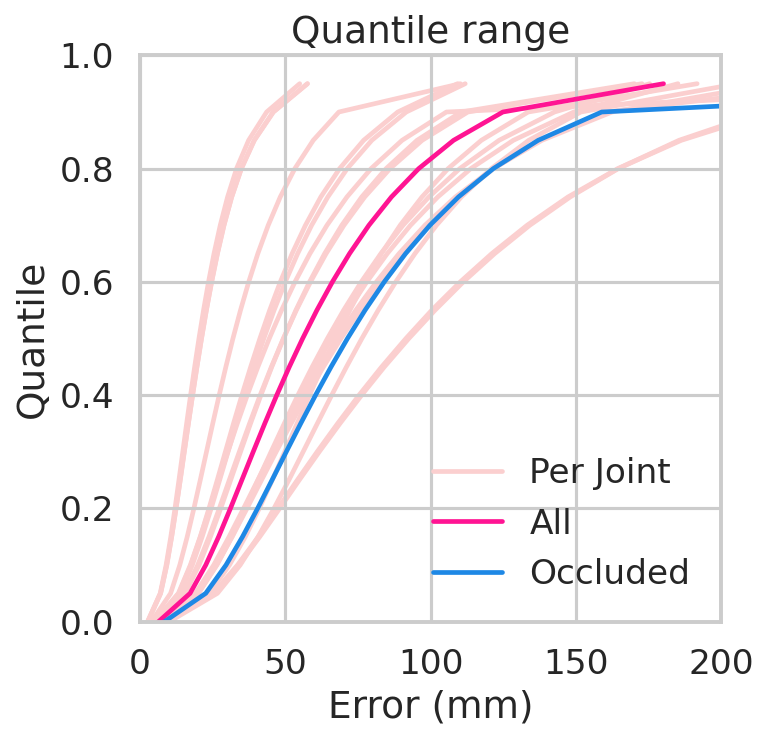

In [372]:
sns.set_context('talk')
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(5, 5), dpi=150)
    plt.plot(np.mean(np.array(q_val).squeeze(), axis=(0))[:-1], quantiles[:-1], c='#FBCFCF', alpha=1, zorder=-1)
    plt.plot(np.mean(np.array(q_val).squeeze(), axis=(0))[:-1, 0], quantiles[:-1], c='#FBCFCF', alpha=1, zorder=-1, label='Per Joint')
    plt.plot(np.mean(np.array(q_val).squeeze(), axis=(0, 2))[:-1], quantiles[:-1], c='deeppink', label='All')
    plt.plot(np.mean(np.array(q_val_occluded).squeeze(), axis=(0, 2))[:-1], quantiles[:-1], c='#1E88E5', label='Occluded')
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.ylabel('Quantile')
    plt.xlabel('Error (mm)')
    plt.ylim(0, 1)
    plt.xlim(0, 200)
    plt.title('Quantile range')
    plt.legend(frameon=False)
plt.savefig('quantile_distance.png', dpi=100, bbox_inches='tight')

In [41]:
quantile_freqs_occluded

array([[0.00486507],
       [0.03368127],
       [0.05829389],
       [0.09050653],
       [0.12315613],
       [0.16026621],
       [0.19845248],
       [0.24814702],
       [0.29984626],
       [0.34945786],
       [0.40972812],
       [0.4692317 ],
       [0.52923494],
       [0.59047214],
       [0.64848687],
       [0.70972408],
       [0.76930453],
       [0.83319578],
       [0.90128454],
       [0.95272687],
       [0.99490432]])

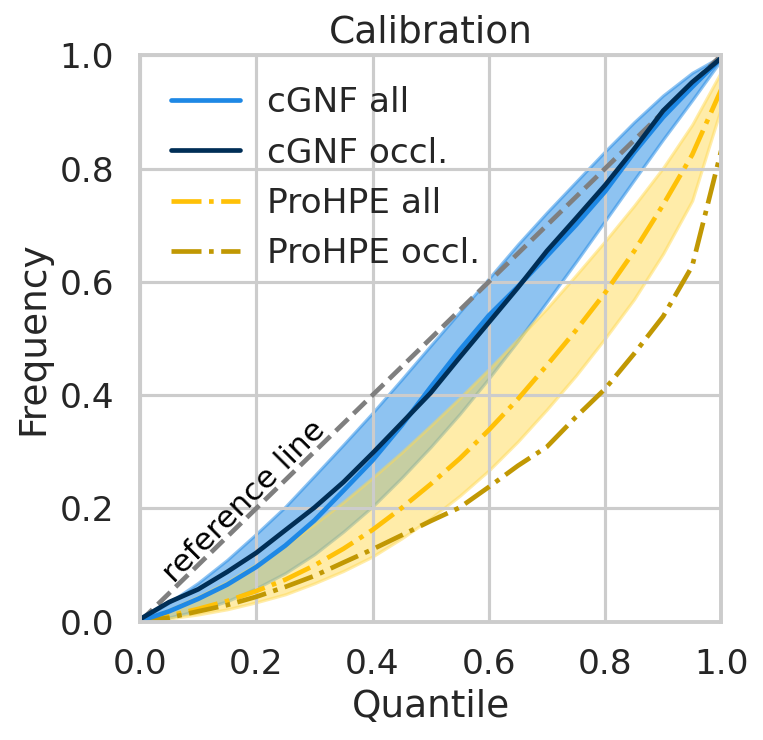

In [103]:
sns.set_context('talk')
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(5, 5), dpi=150)
    plt.fill_between(quantiles,
                     np.mean(quantile_freqs, axis=1) + np.std(quantile_freqs, axis=1),
                     np.mean(quantile_freqs, axis=1) - np.std(quantile_freqs, axis=1),
                     color='#1E88E5', alpha=.5, zorder=-5, rasterized=True)
#     plt.plot(quantiles, np.mean(quantile_freqs, axis=1) - np.std(quantile_freqs, axis=1), c='#FBCFCF', alpha=1, zorder=-1)
#     plt.plot(quantiles, quantile_freqs[:, 0], c='#FBCFCF', alpha=1, zorder=-1, label='cGNF Per Joint')
    plt.plot([0, 1], [0, 1], ls='--', c='tab:gray')
    plt.plot(quantiles, np.median(quantile_freqs, axis=1), c='#1E88E5', alpha=1, label='cGNF all')
    plt.plot(quantiles, np.median(quantile_freqs_occluded, axis=1), c='#002E56', alpha=1, label='cGNF occl.')

#     plt.plot(quantiles, quantile_freqs_wehr, c='#D7E5F0', zorder=-2)
    plt.fill_between(quantiles,
                     np.mean(quantile_freqs_wehr, axis=1) + np.std(quantile_freqs_wehr, axis=1),
                     np.mean(quantile_freqs_wehr, axis=1) - np.std(quantile_freqs_wehr, axis=1),
                     color='#FFDA54', alpha=.5, zorder=-5, rasterized=True)

    plt.plot(quantiles, np.median(quantile_freqs_wehr, axis=1), c='#FFC107', zorder=1, label='ProHPE all', ls='-.')
    plt.plot(quantiles, np.median(quantile_freqs_wehr_occluded, axis=1), c='#C19803', zorder=1, label='ProHPE occl.', ls='-.')
    plt.xticks(np.arange(0, 1.2, 0.2))
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.xlabel('Quantile')
    plt.ylabel('Frequency')
    plt.text(.03, .07, 'reference line', rotation=45, c='k', fontsize=15)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('Calibration')
    plt.legend(frameon=False)
    
    plt.gca().set_rasterization_zorder(-1)

plt.savefig('./calibration.pdf', dpi=100, bbox_inches='tight')
# plt.savefig('./calibration.png', dpi=100, bbox_inches='tight')
plt.show()

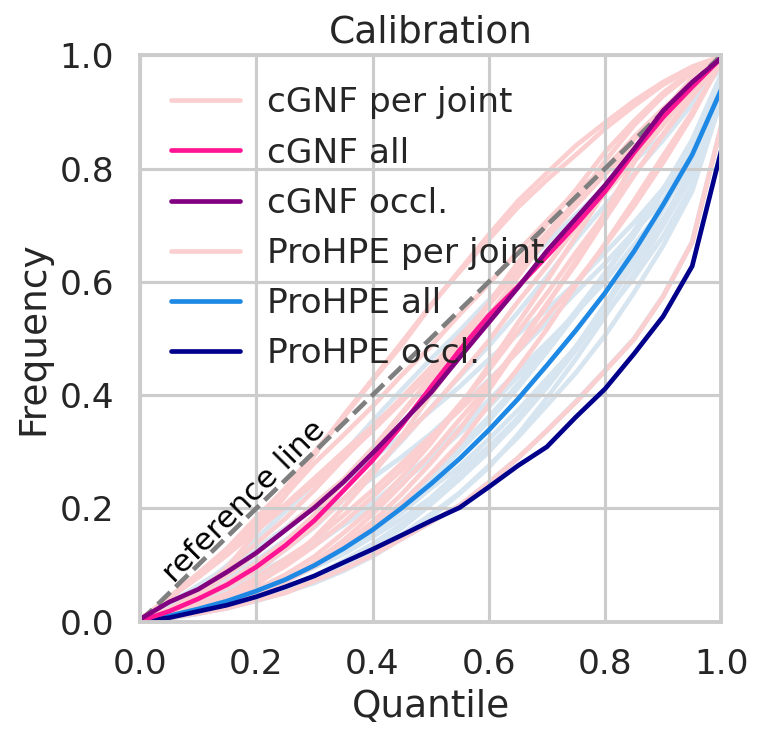

In [67]:
sns.set_context('talk')
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(5, 5), dpi=150)
    plt.plot(quantiles, quantile_freqs, c='#FBCFCF', alpha=1, zorder=-1)
    plt.plot(quantiles, quantile_freqs[:, 0], c='#FBCFCF', alpha=1, zorder=-1, label='cGNF per joint')
    plt.plot([0, 1], [0, 1], ls='--', c='tab:gray')
    plt.plot(quantiles, np.median(quantile_freqs, axis=1), c='deeppink', alpha=1, label='cGNF all')
    plt.plot(quantiles, np.median(quantile_freqs_occluded, axis=1), c='purple', alpha=1, label='cGNF occl.')

    plt.plot(quantiles, quantile_freqs_wehr, c='#D7E5F0', zorder=-2)
    plt.plot(quantiles, quantile_freqs_wehr[:, 0], c='#FBCFCF', alpha=1, zorder=-1, label='ProHPE per joint')
    plt.plot(quantiles, np.median(quantile_freqs_wehr, axis=1), c='#1E88E5', zorder=1, label='ProHPE all')
    plt.plot(quantiles, np.median(quantile_freqs_wehr_occluded, axis=1), c='darkblue', zorder=1, label='ProHPE occl.')
    plt.xticks(np.arange(0, 1.2, 0.2))
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.xlabel('Quantile')
    plt.ylabel('Frequency')
    plt.text(.03, .07, 'reference line', rotation=45, c='k', fontsize=15)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('Calibration')
    plt.legend(frameon=False)
    
plt.savefig('./calibration.pdf', dpi=100, bbox_inches='tight')
# plt.savefig('./calibration.png', dpi=100, bbox_inches='tight')
plt.show()

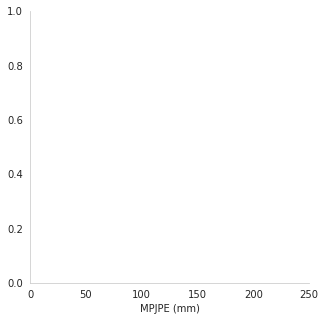

In [52]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(5, 5))
    sns.histplot(np.array(errors).flatten(), bins=np.linspace(0, 250, 50), stat='density', color='k')
    plt.xlim(0, 250)
    plt.grid(False)
    sns.despine(trim=True)
    plt.xlabel('MPJPE (mm)')

In [42]:
wehrbein_results = np.array([51.06, 51.2, 51.05])
wehrbein_results.mean(), wehrbein_results.std() / np.sqrt(wehrbein_results.shape[0])

(51.10333333333333, 0.03953432638812803)

In [44]:
wehrbein_results = np.array([70.89, 70.91, 70.86, 70.86, 70.89])
wehrbein_results.mean(), wehrbein_results.std() / np.sqrt(wehrbein_results.shape[0])

(70.882, 0.008671793355471236)

In [ ]:
wehrbein_results = np.array([44.25, 44.30, 44.24, 44.27, 44.26])
wehrbein_results.mean(), wehrbein_results.std() / np.sqrt(wehrbein_results.shape[0])